# Analysis of misclassified examples

This notebook serves as a visulization of misclassified examples in the pretrained model.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import math
from glob import glob
import os
import sys
from keras.models import load_model
model = None

Using TensorFlow backend.


# Using saved model to directly predict on train set

## Load and preprocess training images

In [2]:
master = pd.read_csv("../input/train_labels.csv")
img_path = "../input/train/"

y = []
file_paths = []
for i in range(len(master)):
    file_paths.append( img_path + str(master.iloc[i, 0]) +'.jpg' ) # .ix same as .iloc
    y.append(master.iloc[i,1])
y = np.array(y)

### Aside

In [45]:
def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_LANCZOS4)
    return img

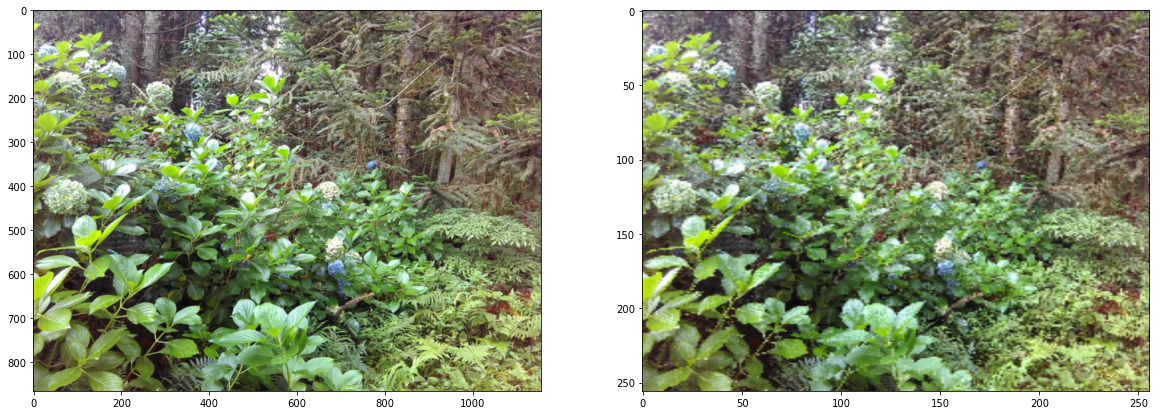

In [49]:
img_raw = cv2.imread(file_paths[10])
img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
img_pro = read_img(file_paths[10])
img_pro = cv2.cvtColor(img_pro, cv2.COLOR_BGR2RGB)
fig, axes = plt.subplots(1,2, figsize=(20,7))
axes[0].imshow(img_raw, interpolation='gaussian', aspect='auto')
axes[1].imshow(img_pro, interpolation='gaussian', aspect='auto')

In [3]:
#image resize & centering & crop 

def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

In [18]:
X = []
for i, file_path in enumerate(file_paths):
    sys.stdout.write("\r {0} from total {1} images".format(file_path, len(file_paths)))
    sys.stdout.flush()
    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #resize
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))
    img = cv2.resize(img, dsize=tile_size)

    #centering
    img = centering_image(img)

    #out put 224*224px 
    img = img[16:240, 16:240]

    X.append(img)

X = np.array(X)

 ../input/train/2295.jpg from total 2295 images

In [19]:
X = X.astype('float32')
X /= 255

## Load saved model `VGG16-transferlearning.model`

In [20]:
if not model:
    model = load_model('VGG16-transferlearning.model')

In [21]:
y_pred = model.predict(X)

## Compare label and predictions

In [22]:
y_pred_cls = (y_pred > 0.5).astype('int')

In [23]:
df_pred1 = master.copy()
df_pred1['probability'] = y_pred
df_pred1['predictions'] = y_pred_cls
df_pred1['misclassified'] = (df_pred1.invasive == df_pred1.predictions).astype('int')

In [24]:
misclass_id1 = df_pred1[df_pred1.misclassified == 0]
misclass_id1

name  invasive  probability  predictions  misclassified
19      20         1     0.155262            0              0
28      29         1     0.009102            0              0
106    107         1     0.035240            0              0
230    231         1     0.053432            0              0
303    304         1     0.238809            0              0
312    313         1     0.385064            0              0
318    319         1     0.294557            0              0
398    399         1     0.477296            0              0
498    499         1     0.097066            0              0
536    537         1     0.346659            0              0
539    540         1     0.222660            0              0
584    585         1     0.423343            0              0
1325  1326         1     0.052252            0              0
1628  1629         1     0.156717            0              0
1665  1666         1     0.372382            0              0
1672  1673         1     0.273891            0              0
1771  1772         1     0.058014            0              0
1845  1846         1     0.361014            0              0
1903  1904         1     0.023324            0              0
2182  2183         1     0.463836            0              0

## Visualization of misclassified images

### Individual plot

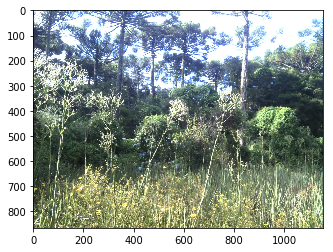

In [11]:
i = 231
file_path = '../input/train/'+str(i)+'.jpg'
img = cv2.imread(file_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure(figsize=(15,20))
plt.imshow(img)

### Grouped Plot

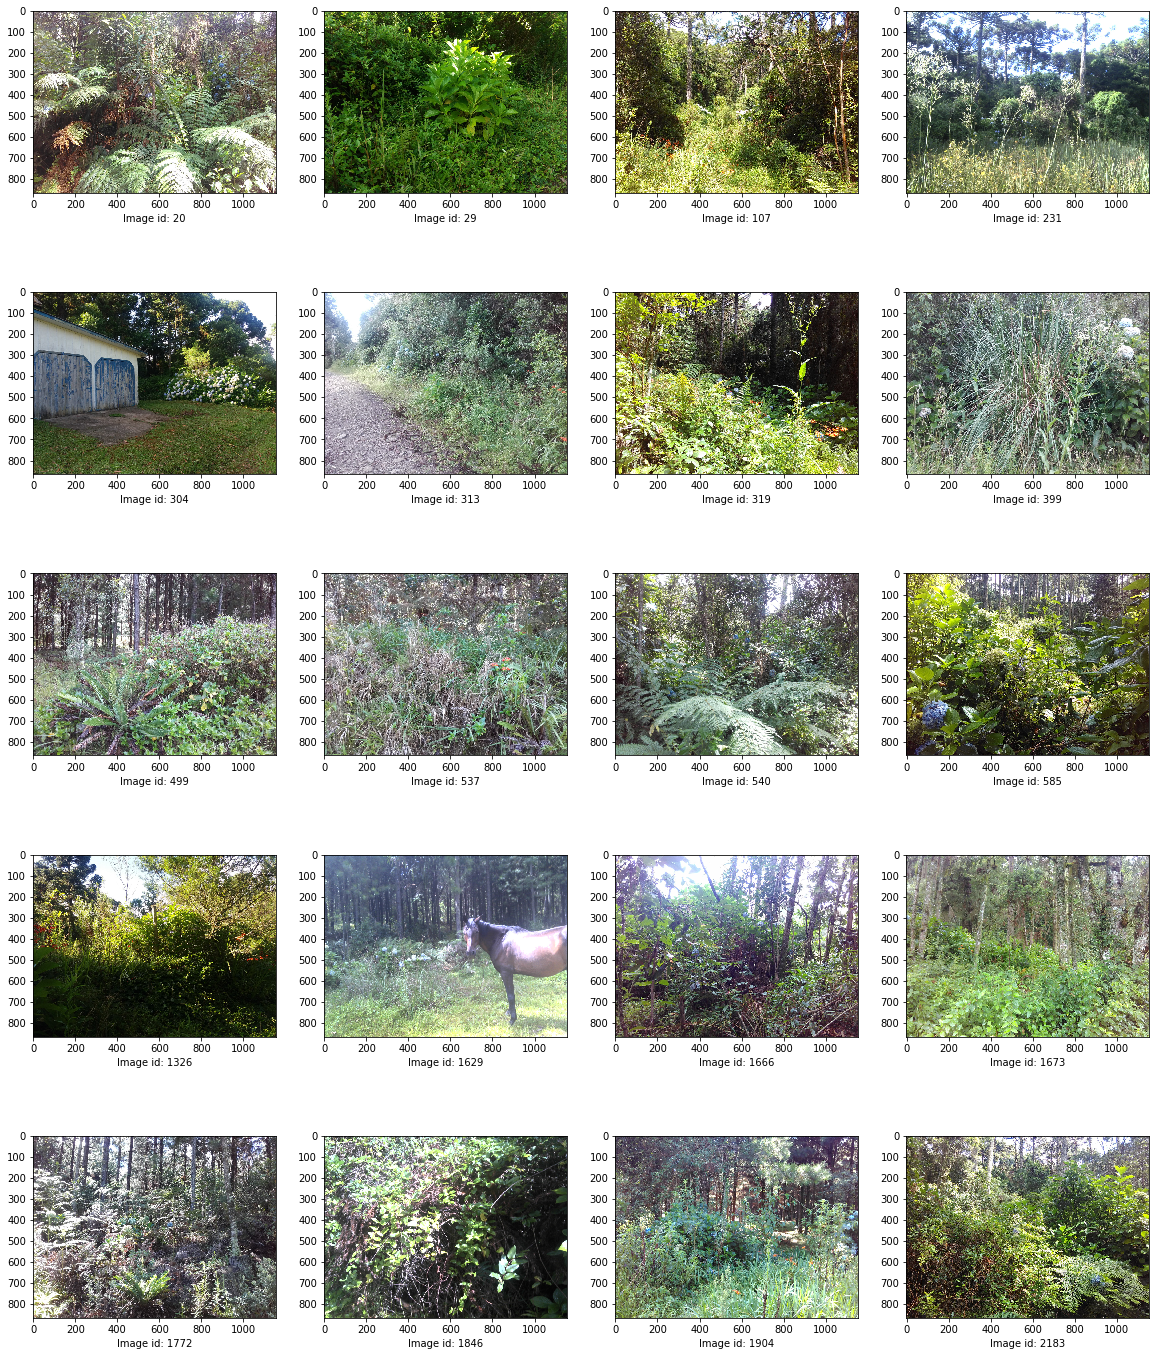

In [14]:
ids = misclass_id.name
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
for i, ax in enumerate(axes.flat):
    file_path = '../input/train/'+str(ids.iloc[i])+'.jpg'
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_xlabel('Image id: {}'.format(ids.iloc[i]))
#plt.tight_layout()
plt.show()

# Testing split images into 9x9 blocks

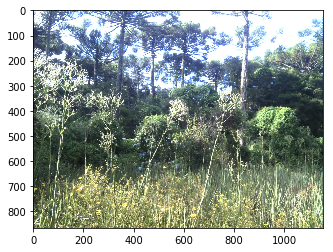

In [15]:
i = 231
file_path = '../input/train/'+str(i)+'.jpg'
img = cv2.imread(file_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure(figsize=(15,20))
plt.imshow(img)

In [16]:
i = 231
file_path = '../input/train/'+str(i)+'.jpg'

img = cv2.imread(file_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ll, ww = img.shape[0]//3, img.shape[1]//3

sub_images = []
for i in range(3):
    for j in range(3):
        sub_img = img[i*ll:(i+1)*ll, j*ww:(j+1)*ww, :]

        #resize
        if(sub_img.shape[0] > sub_img.shape[1]):
            tile_size = (int(sub_img.shape[1]*256/sub_img.shape[0]),256)
        else:
            tile_size = (256, int(sub_img.shape[0]*256/sub_img.shape[1]))

        #centering
        sub_img = centering_image(cv2.resize(sub_img, dsize=tile_size))
    
        #output 224*224px 
        sub_img = sub_img[16:240, 16:240]
        sub_images.append(sub_img)
sub_images = np.array(sub_images)
sub_images.shape

(9, 224, 224, 3)

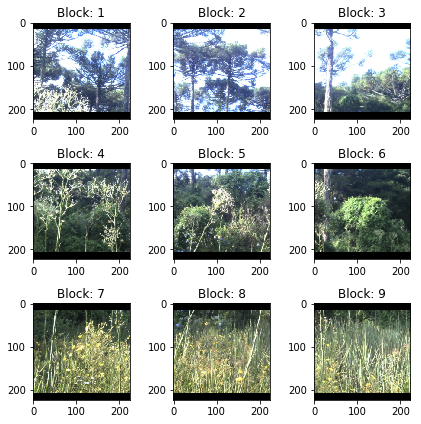

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(sub_images[i, :, :, :])
    ax.set_title('Block: {}'.format(i+1))
plt.tight_layout()
plt.show()

# Make predictions again with 9x9 blocks of training set

## Split into 9x9 blocks

In [ ]:
X = []
for file_path in file_paths:
    sys.stdout.write("\r {0} from total {1} images".format(file_path, len(file_paths)))
    sys.stdout.flush()
    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ll, ww = img.shape[0]//3, img.shape[1]//3
    sub_images = []
    for i in range(3):
        for j in range(3):
            sub_img = img[i*ll:(i+1)*ll, j*ww:(j+1)*ww, :]

            #resize
            if(sub_img.shape[0] > sub_img.shape[1]):
                tile_size = (int(sub_img.shape[1]*256/sub_img.shape[0]),256)
            else:
                tile_size = (256, int(sub_img.shape[0]*256/sub_img.shape[1]))

            #centering
            sub_img = centering_image(cv2.resize(sub_img, dsize=tile_size))
    
            #output 224*224px 
            sub_img = sub_img[16:240, 16:240]
            sub_img = sub_img.astype('float32')
            sub_img /= 255.0
            sub_images.append(sub_img)
    X.append(sub_images)

X = np.array(X)

 ../input/train/1215.jpg from total 2295 images

In [5]:
inshape = X.shape
inshape

(2295, 9, 224, 224, 3)

## Reshape array X and normalize

In [6]:
X = X.reshape((-1, ) + inshape[-3:])

## Load saved model `VGG16-transferlearning.model`

In [9]:
if not model: 
    model = load_model('VGG16-transferlearning.model')

In [10]:
y_pred = model.predict(X)

In [11]:
y_pred.shape

(20655, 1)

In [12]:
y_pred = y_pred.reshape(inshape[:2])

In [13]:
y_pred = np.amax(y_pred, axis=1)

## Compare label and predictions

In [14]:
y_pred_cls = (y_pred > 0.5).astype('int')

In [15]:
df_pred2 = master.copy()
df_pred2['probability'] = y_pred
df_pred2['predictions'] = y_pred_cls
df_pred2['misclassified'] = (df_pred2.invasive == df_pred2.predictions).astype('int')

In [25]:
pd.set_option('display.max_rows', 1000)
misclass_id2 = df_pred2[df_pred2.misclassified == 0]
misclass_id2

name  invasive  probability  predictions  misclassified
9       10         0     0.752820            1              0
15      16         0     0.965440            1              0
16      17         0     0.888571            1              0
23      24         0     0.878687            1              0
30      31         0     0.999916            1              0
37      38         0     0.754771            1              0
40      41         0     0.984716            1              0
48      49         0     0.782671            1              0
49      50         0     0.722655            1              0
52      53         0     0.658109            1              0
87      88         0     0.915610            1              0
91      92         0     0.996362            1              0
114    115         0     0.985682            1              0
120    121         0     0.969379            1              0
121    122         0     0.975001            1              0
122    123         0     0.714164            1              0
123    124         0     0.995162            1              0
128    129         0     0.999111            1              0
140    141         0     0.786359            1              0
148    149         0     0.835307            1              0
157    158         0     0.682671            1              0
162    163         0     0.687650            1              0
168    169         1     0.496357            0              0
170    171         0     0.817114            1              0
177    178         0     0.818833            1              0
180    181         0     0.686947            1              0
183    184         0     0.951072            1              0
192    193         0     0.959536            1              0
207    208         0     0.826829            1              0
209    210         0     0.999545            1              0
212    213         0     0.705211            1              0
213    214         0     0.560073            1              0
218    219         0     0.856566            1              0
221    222         0     0.944211            1              0
230    231         1     0.115529            0              0
231    232         0     0.790451            1              0
235    236         0     0.923326            1              0
237    238         0     0.894075            1              0
238    239         0     0.739980            1              0
249    250         0     0.972023            1              0
252    253         0     0.791762            1              0
262    263         0     0.995578            1              0
289    290         0     0.760113            1              0
302    303         0     0.998730            1              0
304    305         0     0.998509            1              0
309    310         0     0.563970            1              0
321    322         0     0.979620            1              0
322    323         0     0.987668            1              0
324    325         0     0.626086            1              0
325    326         0     0.879808            1              0
342    343         0     0.780566            1              0
360    361         0     0.759568            1              0
364    365         0     0.768111            1              0
374    375         0     0.637397            1              0
384    385         0     0.996215            1              0
386    387         0     0.992009            1              0
391    392         0     0.729690            1              0
402    403         0     0.988590            1              0
409    410         0     0.781253            1              0
419    420         1     0.360607            0              0
425    426         1     0.418889            0              0
427    428         0     0.746757            1              0
428    429         0     0.987524            1              0
430    431         0     0.998657     

In [34]:
compare_12 = df_pred2[[x in misclass_id1.name.values for x in df_pred2.name.values]]
compare_12

name  invasive  probability  predictions  misclassified
19      20         1     0.956041            1              1
28      29         1     0.992616            1              1
106    107         1     0.996993            1              1
230    231         1     0.115529            0              0
303    304         1     1.000000            1              1
312    313         1     0.999242            1              1
318    319         1     0.997896            1              1
398    399         1     0.650217            1              1
498    499         1     0.999991            1              1
536    537         1     0.956103            1              1
539    540         1     0.879300            1              1
584    585         1     0.988543            1              1
1325  1326         1     0.950980            1              1
1628  1629         1     0.991882            1              1
1665  1666         1     0.989954            1              1
1672  1673         1     0.991850            1              1
1771  1772         1     0.427137            0              0
1845  1846         1     0.995107            1              1
1903  1904         1     0.981500            1              1
2182  2183         1     0.999900            1              1

## Specific test

In [6]:
if not model: 
    model = load_model('VGG16-transferlearning.model')

In [35]:
i = 304
y_pred = model.predict(X[i-1])

In [36]:
y_pred

array([[  1.01672970e-01],
       [  1.17711909e-03],
       [  5.38125277e-01],
       [  2.59983842e-03],
       [  9.99970198e-01],
       [  1.00000000e+00],
       [  6.44080807e-04],
       [  1.73159898e-03],
       [  1.30972546e-03]], dtype=float32)

### Show image cuts

In [37]:
file_path = '../input/train/'+str(i)+'.jpg'

img = cv2.imread(file_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ll, ww = img.shape[0]//3, img.shape[1]//3

sub_images = []
for i in range(3):
    for j in range(3):
        sub_img = img[i*ll:(i+1)*ll, j*ww:(j+1)*ww, :]

        #resize
        if(sub_img.shape[0] > sub_img.shape[1]):
            tile_size = (int(sub_img.shape[1]*256/sub_img.shape[0]),256)
        else:
            tile_size = (256, int(sub_img.shape[0]*256/sub_img.shape[1]))

        #centering
        sub_img = centering_image(cv2.resize(sub_img, dsize=tile_size))
    
        #output 224*224px 
        sub_img = sub_img[16:240, 16:240]
        sub_images.append(sub_img)
sub_images = np.array(sub_images)
sub_images.shape

(9, 224, 224, 3)

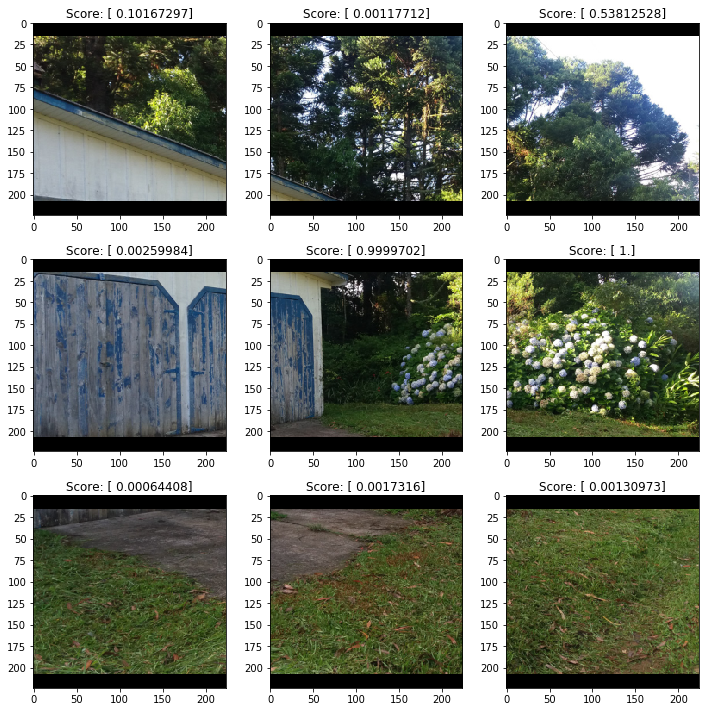

In [38]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(sub_images[i, :, :, :])
    ax.set_title('Score: {}'.format(y_pred[i]))
plt.tight_layout()
plt.show()

# Try again with 2x2 blocks

In [4]:
X = []
for file_path in file_paths:
    sys.stdout.write("\r {0} from total {1} images".format(file_path, len(file_paths)))
    sys.stdout.flush()
    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ll, ww = img.shape[0]//2, img.shape[1]//2
    sub_images = []
    for i in range(2):
        for j in range(2):
            sub_img = img[i*ll:(i+1)*ll, j*ww:(j+1)*ww, :]

            #resize
            if(sub_img.shape[0] > sub_img.shape[1]):
                tile_size = (int(sub_img.shape[1]*256/sub_img.shape[0]),256)
            else:
                tile_size = (256, int(sub_img.shape[0]*256/sub_img.shape[1]))

            #centering
            sub_img = centering_image(cv2.resize(sub_img, dsize=tile_size))
    
            #output 224*224px 
            sub_img = sub_img[16:240, 16:240]
            sub_img = sub_img.astype('float32')
            sub_img /= 255.0
            sub_images.append(sub_img)
    X.append(sub_images)

X = np.array(X)

 ../input/train/2295.jpg from total 2295 images

In [5]:
inshape = X.shape
inshape

(2295, 4, 224, 224, 3)

## Reshape array X and normalize

In [7]:
X = X.reshape((-1, ) + inshape[-3:])

## Load saved model VGG16-transferlearning.model

In [8]:
if not model: 
    model = load_model('VGG16-transferlearning.model')

In [9]:
y_pred = model.predict(X)

In [10]:
y_pred = y_pred.reshape(inshape[:2])
y_pred = np.amax(y_pred, axis=1)

## Compare label and predictions

In [11]:
y_pred_cls = (y_pred > 0.5).astype('int')

In [12]:
df_pred3 = master.copy()
df_pred3['probability'] = y_pred
df_pred3['predictions'] = y_pred_cls
df_pred3['misclassified'] = (df_pred3.invasive == df_pred3.predictions).astype('int')

In [14]:
pd.set_option('display.max_rows', 1000)
misclass_id3 = df_pred3[df_pred3.misclassified == 0]
misclass_id3

name  invasive  probability  predictions  misclassified
0        1         0     0.641813            1              0
30      31         0     0.979229            1              0
35      36         1     0.091952            0              0
40      41         0     0.902097            1              0
81      82         1     0.218392            0              0
106    107         1     0.033998            0              0
120    121         0     0.559933            1              0
123    124         0     0.958251            1              0
128    129         0     0.952001            1              0
140    141         0     0.611949            1              0
142    143         1     0.037941            0              0
160    161         1     0.341002            0              0
176    177         1     0.007563            0              0
183    184         0     0.734587            1              0
184    185         1     0.240149            0              0
190    191         1     0.327091            0              0
192    193         0     0.629556            1              0
208    209         0     0.825550            1              0
209    210         0     0.994083            1              0
221    222         0     0.973398            1              0
230    231         1     0.154638            0              0
262    263         0     0.901024            1              0
263    264         1     0.326274            0              0
267    268         1     0.115894            0              0
302    303         0     0.995016            1              0
304    305         0     0.967695            1              0
320    321         1     0.318557            0              0
342    343         0     0.580534            1              0
390    391         0     0.570996            1              0
394    395         1     0.447186            0              0
402    403         0     0.930101            1              0
409    410         0     0.723274            1              0
418    419         1     0.227631            0              0
425    426         1     0.073011            0              0
430    431         0     0.531094            1              0
433    434         0     0.920478            1              0
481    482         0     0.649057            1              0
484    485         1     0.099830            0              0
485    486         0     0.992641            1              0
491    492         1     0.150777            0              0
513    514         0     0.970805            1              0
522    523         0     0.812526            1              0
544    545         0     0.811892            1              0
548    549         0     0.770889            1              0
549    550         1     0.352982            0              0
553    554         0     0.999998            1              0
578    579         0     0.989341            1              0
587    588         0     0.999997            1              0
616    617         1     0.026230            0              0
620    621         0     0.763702            1              0
651    652         0     0.631934            1              0
679    680         0     0.963243            1              0
681    682         0     0.874981            1              0
695    696         1     0.037768            0              0
717    718         0     0.960645            1              0
752    753         1     0.481259            0              0
755    756         0     0.740425            1              0
764    765         0     0.855064            1              0
774    775         0     0.617523            1              0
779    780         1     0.001336            0              0
785    786         0     0.994733            1              0
801    802         0     0.861138            1              0
808    809         1     0.006656            0              0
827    828         0     0.975652     

## Specific test on 4x4 block examples

In [8]:
if not model: 
    model = load_model('VGG16-transferlearning.model')

In [39]:
i = 264
y_pred = model.predict(X[i-1])
y_pred

array([[ 0.12407391],
       [ 0.32627293],
       [ 0.000628  ],
       [ 0.00043488]], dtype=float32)

### Show image cuts

In [40]:
file_path = '../input/train/'+str(i)+'.jpg'

img = cv2.imread(file_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ll, ww = img.shape[0]//2, img.shape[1]//2

sub_images = []
for i in range(2):
    for j in range(2):
        sub_img = img[i*ll:(i+1)*ll, j*ww:(j+1)*ww, :]

        #resize
        if(sub_img.shape[0] > sub_img.shape[1]):
            tile_size = (int(sub_img.shape[1]*256/sub_img.shape[0]),256)
        else:
            tile_size = (256, int(sub_img.shape[0]*256/sub_img.shape[1]))

        #centering
        sub_img = centering_image(cv2.resize(sub_img, dsize=tile_size))
    
        #output 224*224px 
        sub_img = sub_img[16:240, 16:240]
        sub_images.append(sub_img)
sub_images = np.array(sub_images)
sub_images.shape

(4, 224, 224, 3)

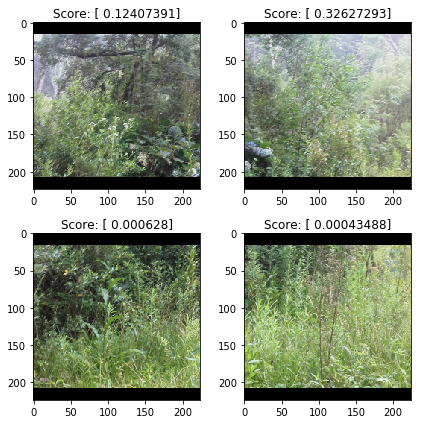

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(sub_images[i, :, :, :])
    ax.set_title('Score: {}'.format(y_pred[i]))
plt.tight_layout()
plt.show()